In [1]:
from scipy.io import netcdf
import numpy as np
from pylab import clf, plot, show, floor, ceil, imshow
import matplotlib
import matplotlib.pyplot as plt 
from netCDF4 import Dataset
%matplotlib inline
#xlabel, ylabel, legend, savefig, colorbar, title, clim, pcolor, cm, contourf
import os
import csv
import sys
import glob
import random 
from IPython.display import display, Math, Latex, Image
from mpl_toolkits.basemap import Basemap
sys.path.append('/noc/users/am8e13/Python/PyNIO-1.4.1/')
import Nio
sys.path.append('/noc/users/am8e13/PyNGL-1.4.0/lib/python2.7/site-packages/PyNGL/')
import Ngl
sys.path.append('/noc/users/am8e13/Python/')
import komod


In [2]:
def volume_calc(res):
    if res == 36:
        x="/scratch/general/am8e13/results36km"
    elif res == 18:
        x="/scratch/general/am8e13/results18km"
    
    os.chdir(x)
    file2read = netcdf.NetCDFFile("grid.nc",'r')
    hfacw = file2read.variables['HFacW']
    hfacw = hfacw[:]*1
    dyG = file2read.variables['dyG']
    dyG = dyG[:]*1   
    dxG = file2read.variables['dxG']
    dxG = dxG[:]*1  
    
    hfacs = file2read.variables['HFacS']
    hfacs = hfacs[:]*1
    dyU = file2read.variables['dyU']
    dyU = dyU[:]*1
    dxV = file2read.variables['dxV']
    dxV = dxV[:]*1    
    drf = file2read.variables['drF']
    drf = drf[:]*1
    
    # uFlux = uVel(i,j,k,bi,bj)*hFacW(i,j,k,bi,bj)*dyG(i,j,bi,bj)*drF(k)
    # vFlux = vVel(i,j,k,bi,bj)*hFacS(i,j,k,bi,bj)*dyG(i,j,bi,bj)*drF(k)
    
    # Volume calculation  
    dydz_u = np.zeros_like(hfacw)                                                                                             
    for i in range(dyG.shape[0]-1):
        for j in range(dyG.shape[1]):
            for k in range(drf.shape[0]):
                dydz_u[k,i,j] = drf[k]*dyG[i,j]*hfacw[k,i,j]
    
    dydz_v = np.zeros_like(hfacs)                                                                                             
    for i in range(dyG.shape[0]):
        for j in range(dyG.shape[1]-1):
            for k in range(drf.shape[0]):
                dydz_v[k,i,j] = drf[k]*dyG[i,j]*hfacs[k,i,j]  
                
    dxdz_u = np.zeros_like(hfacw)                                                                                             
    for i in range(dxG.shape[0]-1):
        for j in range(dxG.shape[1]):
            for k in range(drf.shape[0]):
                dxdz_u[k,i,j] = drf[k]*dxG[i,j]*hfacw[k,i,j]
                
    dxdz_v = np.zeros_like(hfacs)                                                                                             
    for i in range(dxV.shape[0]):
        for j in range(dxV.shape[1]-1):
            for k in range(drf.shape[0]):
                dxdz_v[k,i,j] = drf[k]*dxG[i,j]*hfacs[k,i,j]
    
    return dydz_u, dydz_v, dxdz_u, dxdz_v

dydz_u_18, dydz_v_18, dxdz_u_18, dxdz_v_18 = volume_calc(18)
dydz_u_36, dydz_v_36, dxdz_u_36, dxdz_v_36 = volume_calc(36)

def volume_selection(res):
    if res == 18:
        dydz_u = dydz_u_18 
        dydz_v = dydz_v_18
        dxdz_u = dxdz_u_18
        dxdz_v = dxdz_v_18
    elif res == 36:
        dydz_u = dydz_u_36 
        dydz_v = dydz_v_36
        dxdz_u = dxdz_u_36
        dxdz_v = dxdz_v_36    
    
    return dydz_u, dydz_v, dxdz_u, dxdz_v

In [3]:
def calculate_fluxes_ob(dic_data,res):
    
    dydz_u, dydz_v, dxdz_u, dxdz_v = volume_selection(res)
    
    if res == 18:
        nx = 420
        ny = 384
    elif res == 36:
        nx = 210
        ny = 192

    Wv_flux = np.zeros(dic_data['Wv'].shape[0])
    Wu_flux = np.zeros(dic_data['Wv'].shape[0])
    Ev_flux = np.zeros(dic_data['Wv'].shape[0])
    Eu_flux = np.zeros(dic_data['Wv'].shape[0])
    Nv_flux = np.zeros(dic_data['Wv'].shape[0])
    Nu_flux = np.zeros(dic_data['Wv'].shape[0])
    
    for t in range(dic_data['Wv'].shape[0]):
        Wv_flux[t] = np.mean(np.sum(vel[t,:,:,:]*dydz_v[:,0:ny,1])) ;
        Wu_flux[t] = np.mean(np.sum(dic_data['Wu'][t,:,:]*dydz_u[:,0:ny,1])) ;
        Ev_flux[t] = np.mean(np.sum(dic_data['Ev'][t,:,:]*dydz_v[:,0:ny,nx-1])) ;
        Eu_flux[t] = np.mean(np.sum(dic_data['Eu'][t,:,:]*dydz_u[:,0:ny,nx-1])) ;
        Nv_flux[t] = np.mean(np.sum(np.squeeze(dic_data['Nv'][t,:,:])*dxdz_v[:,ny-1,0:nx])) ;
        Nu_flux[t] = np.mean(np.sum(np.squeeze(dic_data['Nu'][t,:,:])*dxdz_u[:,ny-1,0:nx])) ;
    
    Wv_flux_temp=[]
    Wu_flux_temp=[]
    Ev_flux_temp=[]
    Eu_flux_temp=[]
    Nv_flux_temp=[]
    Nu_flux_temp=[]
    
    if dic_data['Wv'].shape[0] == 12:
        for year in range(10):
            Wv_flux_temp = np.concatenate([Wv_flux_temp, Wv_flux])
            Wu_flux_temp = np.concatenate([Wu_flux_temp, Wu_flux])
            Ev_flux_temp = np.concatenate([Ev_flux_temp, Ev_flux])
            Eu_flux_temp = np.concatenate([Eu_flux_temp, Eu_flux])
            Nv_flux_temp = np.concatenate([Nv_flux_temp, Nv_flux])
            Nu_flux_temp = np.concatenate([Nu_flux_temp, Nu_flux])
    
        Wv_flux = Wv_flux_temp
        Wu_flux = Wu_flux_temp
        Ev_flux = Ev_flux_temp
        Eu_flux = Eu_flux_temp
        Nv_flux = Nv_flux_temp
        Nu_flux = Nu_flux_temp
        
    
    return Wv_flux, Wu_flux, Ev_flux, Eu_flux, Nv_flux, Nu_flux

In [7]:
# This function is meant to read and store the forcing fields
# Load adata files
xdim = 320
ydim = 160
tdim = [365*4,366*4]


era_data = {'v10m': np.zeros(360*33) , 'u10m' : np.zeros(360*33), 'rain': np.zeros(360*33), \
            'dlw' : np.zeros(360*33) , 'dsw' : np.zeros(360*33) , 'tmp2m_degC' : np.zeros(360*33) , \
            'spfh2m' : np.zeros(360*33), 'rain': np.zeros(360*33),}

era_data_all = {'v10m': np.zeros(360*33*4) , 'u10m' : np.zeros(360*33*4), 'rain': np.zeros(360*33*4), \
            'dlw' : np.zeros(360*33*4) , 'dsw' : np.zeros(360*33*4) , 'tmp2m_degC' : np.zeros(360*33*4) , \
            'spfh2m' : np.zeros(360*33*4), 'rain': np.zeros(360*33*4),}


era_data_ave = {'v10m': np.zeros(360) , 'u10m' : np.zeros(360), 'rain': np.zeros(360), \
            'dlw' : np.zeros(360) , 'dsw' : np.zeros(360) , 'tmp2m_degC' : np.zeros(360) , \
            'spfh2m' : np.zeros(360), 'rain': np.zeros(360*33),}

era_data_ave_all = {'v10m': np.zeros(360*4) , 'u10m' : np.zeros(360*4), 'rain': np.zeros(360*4), \
            'dlw' : np.zeros(360*4) , 'dsw' : np.zeros(360*4) , 'tmp2m_degC' : np.zeros(360*4) , \
            'spfh2m' : np.zeros(360*4), 'rain': np.zeros(360*4),}

for var in era_data:
    data_av = []
    print "Now reading:"+str(var)
    for year in range(22):
        if (year+3)%4 == 0:
            tdim_ly = 1
            n_pop = 6
        else:
            tdim_ly = 0
            n_pop = 5      
            
        name = '/scratch/general/am8e13/ERA_data/ERA40g_'+str(var)+'_'+str(1979+year)
        
        data = komod.mitbin(name,xdim=xdim,ydim=ydim,zdim=1,tdim=tdim[tdim_ly],datatype='float32')
        data_av_temp = np.mean(np.mean(data,axis = 3),axis = 2).squeeze(axis = 1)        
        to_pop = random.sample(range(len(data_av_temp)), 4*n_pop)
        data_av_temp = np.delete(data_av_temp,to_pop,0) 
        era_data_all[var]=data_av_temp
        # Daily average for plotting purpose
        data_av_temp_daily = np.zeros(360)
        for day in range(360):
            data_av_temp_daily[day] = np.mean(data_av_temp[day*4 : day*4 +4])
            
        data_av = np.concatenate([data_av,data_av_temp_daily])
        era_data[var] = data_av
        
    name = '/scratch/general/am8e13/ERA_data/ERA40g_'+str(var)+'_average'
    data = komod.mitbin(name,xdim=xdim,ydim=ydim,zdim=1,tdim=360*4,datatype='float32')
    data_climy_av = np.mean(np.mean(data,axis = 3),axis = 2).squeeze(axis = 1)
    era_data_ave_all[var]=data_climy_av  
    data_climy_av_daily = np.zeros(360)
    for day in range(360):
        data_climy_av_daily[day] = np.mean(data_climy_av[day*4 : day*4 +4])
        
    data_climy_33_years = []
    for year in range(33):
        data_climy_33_years = np.concatenate([data_climy_33_years, data_climy_av_daily])
        
    era_data_ave[var] = data_climy_33_years

Now reading:v10m
Now reading:dlw
Now reading:spfh2m
Now reading:u10m
Now reading:dsw
Now reading:tmp2m_degC
Now reading:rain


In [8]:
# Load adata files
xdim = 320
ydim = 160
tdim = [365*4,366*4]


clim_data = {'v10m': np.zeros(360*33) , 'u10m' : np.zeros(360*33), 'rain_new33': np.zeros(360*33), \
            'dlw' : np.zeros(360*33) , 'dsw' : np.zeros(360*33) , 'tmp2m_degC' : np.zeros(360*33) , \
            'spfh2m' : np.zeros(360*33), 'rain': np.zeros(360*33),}

clim_data_all = {'v10m': np.zeros(360*33*4) , 'u10m' : np.zeros(360*33*4), 'rain_new33': np.zeros(360*33*4), \
            'dlw' : np.zeros(360*33*4) , 'dsw' : np.zeros(360*33*4) , 'tmp2m_degC' : np.zeros(360*33*4) , \
            'spfh2m' : np.zeros(360*33*4), 'rain': np.zeros(360*33*4),}


clim_data_ave = {'v10m': np.zeros(360) , 'u10m' : np.zeros(360), 'rain_new33': np.zeros(360), \
            'dlw' : np.zeros(360) , 'dsw' : np.zeros(360) , 'tmp2m_degC' : np.zeros(360) , \
            'spfh2m' : np.zeros(360), 'rain': np.zeros(360*33),}

clim_data_ave_all = {'v10m': np.zeros(360*4) , 'u10m' : np.zeros(360*4), 'rain_new33': np.zeros(360*4), \
            'dlw' : np.zeros(360*4) , 'dsw' : np.zeros(360*4) , 'tmp2m_degC' : np.zeros(360*4) , \
            'spfh2m' : np.zeros(360*4), 'rain': np.zeros(360*4),}

for var in clim_data:
    data_av = []
    print "Now reading:"+str(var)
    for year in range(33):
        if (year+3)%4 == 0:
            tdim_ly = 1
            n_pop = 6
        else:
            tdim_ly = 0
            n_pop = 5      
            
        name = '/scratch/general/am8e13/cs_36km_tutorial/climdata/jra25_'+str(var)+'_'+str(1979+year)
        
        data = komod.mitbin(name,xdim=xdim,ydim=ydim,zdim=1,tdim=tdim[tdim_ly],datatype='float32')
        data_av_temp = np.mean(np.mean(data,axis = 3),axis = 2).squeeze(axis = 1)        
        to_pop = random.sample(range(len(data_av_temp)), 4*n_pop)
        data_av_temp = np.delete(data_av_temp,to_pop,0) 
        clim_data_all[var]=data_av_temp
        # Daily average for plotting purpose
        data_av_temp_daily = np.zeros(360)
        for day in range(360):
            data_av_temp_daily[day] = np.mean(data_av_temp[day*4 : day*4 +4])
            
        data_av = np.concatenate([data_av,data_av_temp_daily])
        clim_data[var] = data_av
        
    name = '/scratch/general/am8e13/cs_36km_tutorial/clim_year/jra25_'+str(var)+'_average_new'
    data = komod.mitbin(name,xdim=xdim,ydim=ydim,zdim=1,tdim=360*4,datatype='float32')
    data_climy_av = np.mean(np.mean(data,axis = 3),axis = 2).squeeze(axis = 1)
    clim_data_ave_all[var]=data_climy_av  
    data_climy_av_daily = np.zeros(360)
    for day in range(360):
        data_climy_av_daily[day] = np.mean(data_climy_av[day*4 : day*4 +4])
        
    data_climy_33_years = []
    for year in range(33):
        data_climy_33_years = np.concatenate([data_climy_33_years, data_climy_av_daily])
        
    clim_data_ave[var] = data_climy_33_years

Now reading:v10m
Now reading:dlw
Now reading:rain
Now reading:spfh2m
Now reading:u10m
Now reading:rain_new33
Now reading:tmp2m_degC
Now reading:dsw


In [9]:
for var in clim_data_ave:
    data_climy_av_daily = np.zeros(360)
    for day in range(360):
        data_climy_av_daily[day] = np.mean(data_climy_av[day*4 : day*4 +4])
        
    data_climy_33_years = np.array(data_climy_av_daily)
    
for year in range(33):
    data_climy_33_years = np.concatenate([data_climy_33_years, data_climy_av_daily])

In [10]:
titles = {'v10m': 'Meridional wind' , 'u10m' : 'Zonal wind', 'rain_new33': 'Precipitation new33', \
            'dlw' : 'Long wave radiation' , 'dsw' : 'Short wave radiation' , 'tmp2m_degC' : 'Temperature at 2m' , \
            'spfh2m' : 'Specific humidity at 2m', 'rain': 'Precipitation'}

unity = {'v10m': 'm/s' , 'u10m' : 'm/s', 'rain_new33': 'mm/day', \
            'dlw' : 'W/m2' , 'dsw' : 'W/m2' , 'tmp2m_degC' : 'C' , \
            'spfh2m' : 'kg/kg', 'rain': 'mm/day'}

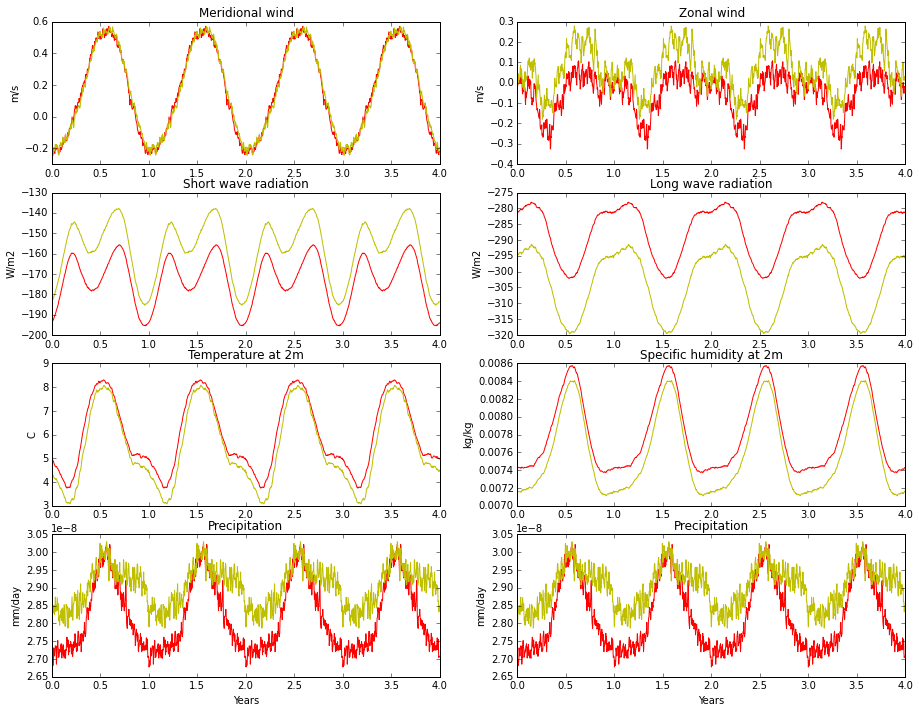

In [16]:
fig, axes = plt.subplots(4,2)
yp =4
ax_ind = 0
ord_var = ['v10m','u10m','dsw','dlw','tmp2m_degC','spfh2m','rain','rain']
#time_obcs= np.array(range(len(obcs_data['Eu'])))/12.

time = np.array(range(len(clim_data['v10m'])))/360.
for var in ord_var:
    if var == 'rain' or var == 'rain_new33':
        axes.flat[ax_ind].set_xlabel('Years')
    if var == 'rain_ne3':
        var='Et'
        #axes.flat[ax_ind].plot(time_obcs[0:12*yp],obcs_data_mean[var][0:12*yp],'b')
        #axes.flat[ax_ind].plot(time_obcs[0:12*yp],obcs_data_ave_mean[var][0:12*yp],'r')
        #axes.flat[ax_ind].set_title(titles_obcs[var])
        #axes.flat[ax_ind].set_title('Lateral Boundary Condition temperature')
        #axes.flat[ax_ind].set_ylabel(unity_obcs[var])     
    else:
        #axes.flat[ax_ind].plot(time[0:360*yp],clim_data[var][0:360*yp],'b')
        axes.flat[ax_ind].plot(time[0:360*yp],clim_data_ave[var][0:360*yp],'r')
        #axes.flat[ax_ind].plot(time[0:360*yp],era_data[var][0:360*yp],'g')
        axes.flat[ax_ind].plot(time[0:360*yp],era_data_ave[var][0:360*yp],'y')
        axes.flat[ax_ind].set_title(titles[var])
        axes.flat[ax_ind].set_ylabel(unity[var])
        ax_ind +=  1
    #yp = 4
    
fig.subplots_adjust(right=2.1,top=2.4)

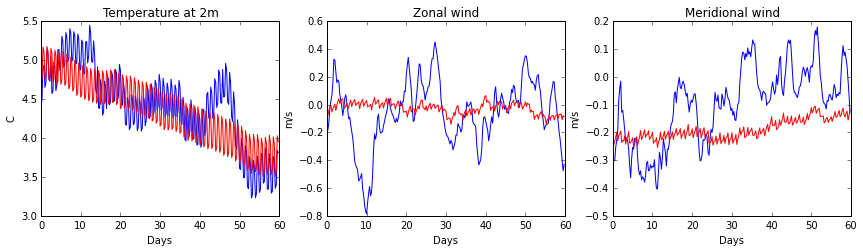

In [65]:
fig, axes = plt.subplots(1,3)
yp = 60
shift = 0
time = np.array(range(len(clim_data['v10m'])))/4.
axes.flat[0].plot(time[ 0:  4*yp],clim_data_all['tmp2m_degC'][shift +0:shift +4*yp],'b')
axes.flat[0].plot(time[0:4*yp],clim_data_ave_all['tmp2m_degC'][shift +0:shift +4*yp],'r')
axes.flat[0].set_title(titles['tmp2m_degC'])
axes.flat[0].set_ylabel(unity['tmp2m_degC'])
axes.flat[0].set_xlabel('Days')

axes.flat[1].plot(time[ 0:  4*yp],clim_data_all['u10m'][shift +0:shift +4*yp],'b')
axes.flat[1].plot(time[0:4*yp],clim_data_ave_all['u10m'][shift +0:shift +4*yp],'r')
axes.flat[1].set_title(titles['u10m'])
axes.flat[1].set_ylabel(unity['u10m'])
axes.flat[1].set_xlabel('Days')

axes.flat[2].plot(time[ 0:  4*yp],clim_data_all['v10m'][shift +0:shift +4*yp],'b')
axes.flat[2].plot(time[0:4*yp],clim_data_ave_all['v10m'][shift +0:shift +4*yp],'r')
axes.flat[2].set_title(titles['v10m'])
axes.flat[2].set_ylabel(unity['v10m'])
axes.flat[2].set_xlabel('Days')

fig.subplots_adjust(right=2.,top=0.8)

In [69]:
# Load adata files
xdim = [210,1]
ydim = [192,1]
zdim = 50
tdim = 12

obcs_data = {'Ev': np.zeros(12*33) , 'Wv' : np.zeros(12*33), 'Nv': np.zeros(12*33), \
            'Eu' : np.zeros(12*33) , 'Wu' : np.zeros(12*33) , 'Nu' : np.zeros(12*33), \
            'Et': np.zeros(12*33) , 'Wt' : np.zeros(12*33), 'Nt': np.zeros(12*33), \
            'Es' : np.zeros(12*33) , 'Ws' : np.zeros(12*33) , 'Ns' : np.zeros(12*33) }

obcs_data_mean = {'Ev': np.zeros(12*33) , 'Wv' : np.zeros(12*33), 'Nv': np.zeros(12*33), \
            'Eu' : np.zeros(12*33) , 'Wu' : np.zeros(12*33) , 'Nu' : np.zeros(12*33), \
            'Et': np.zeros(12*33) , 'Wt' : np.zeros(12*33), 'Nt': np.zeros(12*33), \
            'Es' : np.zeros(12*33) , 'Ws' : np.zeros(12*33) , 'Ns' : np.zeros(12*33) }

obcs_data_ave = {'Ev': np.zeros(12*33) , 'Wv' : np.zeros(12*33), 'Nv': np.zeros(12*33), \
            'Eu' : np.zeros(12*33) , 'Wu' : np.zeros(12*33) , 'Nu' : np.zeros(12*33), \
            'Et': np.zeros(12*33) , 'Wt' : np.zeros(12*33), 'Nt': np.zeros(12*33), \
            'Es' : np.zeros(12*33) , 'Ws' : np.zeros(12*33) , 'Ns' : np.zeros(12*33) }

obcs_data_ave_mean = {'Ev': np.zeros(12*33) , 'Wv' : np.zeros(12*33), 'Nv': np.zeros(12*33), \
            'Eu' : np.zeros(12*33) , 'Wu' : np.zeros(12*33) , 'Nu' : np.zeros(12*33), \
            'Et': np.zeros(12*33) , 'Wt' : np.zeros(12*33), 'Nt': np.zeros(12*33), \
            'Es' : np.zeros(12*33) , 'Ws' : np.zeros(12*33) , 'Ns' : np.zeros(12*33) }

obcs_data_ave_div = {'Ev': np.zeros(12*33) , 'Wv' : np.zeros(12*33), 'Nv': np.zeros(12*33), \
            'Eu' : np.zeros(12*33) , 'Wu' : np.zeros(12*33) , 'Nu' : np.zeros(12*33), \
            'Et': np.zeros(12*33) , 'Wt' : np.zeros(12*33), 'Nt': np.zeros(12*33), \
            'Es' : np.zeros(12*33) , 'Ws' : np.zeros(12*33) , 'Ns' : np.zeros(12*33) }

obcs_data_ave_mean_div = {'Ev': np.zeros(12*33) , 'Wv' : np.zeros(12*33), 'Nv': np.zeros(12*33), \
            'Eu' : np.zeros(12*33) , 'Wu' : np.zeros(12*33) , 'Nu' : np.zeros(12*33), \
            'Et': np.zeros(12*33) , 'Wt' : np.zeros(12*33), 'Nt': np.zeros(12*33), \
            'Es' : np.zeros(12*33) , 'Ws' : np.zeros(12*33) , 'Ns' : np.zeros(12*33) }

for var in obcs_data:
    data_av = []
    print "Now reading:"+str(var)
    if var == 'Nu' or var == 'Nv' or var == 'Ns' or var == 'Nt':
        xdim_i = 0
        ydim_i = 1
    elif var == 'Wu' or var == 'Wv' or var == 'Ws' or var == 'Wt' or \
         var == 'Eu' or var == 'Ev' or var == 'Es' or var == 'Et':
        xdim_i = 1
        ydim_i = 0
            
    if var == 'Es' or var == 'Et' or var == 'Ns' or var == 'Nt' or var == 'Ws' or var == 'Wt':
        stable = 'stable'
        ending = '_climyaverage'
    else:
        stable = 'bin'
        ending = '_zeroed'
        
    name = '/scratch/general/am8e13/cs_36km_tutorial/input_obcs/OB'+str(var)+'_arctic_210x192.'+str(stable)
    data = komod.mitbin(name,xdim=xdim[xdim_i],ydim=ydim[ydim_i],zdim=50,tdim=tdim*10,datatype='float32')
    data_av_temp = np.mean(np.mean(np.mean(data,axis=3),axis=2),1)    
    obcs_data[var] = data #_av_temp
    obcs_data_mean[var] = data_av_temp
    
    name = '/scratch/general/am8e13/cs_36km_tutorial/input_obcs/OB'+str(var)+'_arctic_210x192.'+str(stable)+'_climyaverage'
    data = komod.mitbin(name,xdim=xdim[xdim_i],ydim=ydim[ydim_i],zdim=50,tdim=tdim,datatype='float32')
    data_climy_av = np.mean(np.mean(np.mean(data,axis=3),axis=2),1)
    data_climy_33_years = []
    
    for year in range(10):
        data_climy_33_years = np.concatenate([data_climy_33_years, data_climy_av])
    obcs_data_ave_mean[var] = data_climy_33_years    
    obcs_data_ave[var] = data#_climy_33_years
    
    if var == 'Es' or var == 'Et' or var == 'Ns' or var == 'Nt' or var == 'Ws' or var == 'Wt':
        name = '/scratch/general/am8e13/cs_36km_tutorial/input_obcs/OB'+str(var)+'_arctic_210x192.'+str(stable)+'_climyaverage'
    else:
        name = '/scratch/general/am8e13/cs_36km_tutorial/input_obcs/OB'+str(var)+'_arctic_210x192.'+str(stable)+'_zeroed_div'
    data = komod.mitbin(name,xdim=xdim[xdim_i],ydim=ydim[ydim_i],zdim=50,tdim=tdim,datatype='float32')
    data_climy_av = np.mean(np.mean(np.mean(data,axis=3),axis=2),1)
    data_climy_33_years = []
    
    for year in range(10):
        data_climy_33_years = np.concatenate([data_climy_33_years, data_climy_av])
    obcs_data_ave_mean_div[var] = data_climy_33_years    
    obcs_data_ave_div[var] = data#_climy_33_years

Now reading:Ns
Now reading:Nt
Now reading:Nu
Now reading:Nv
Now reading:Wv
Now reading:Wu
Now reading:Wt
Now reading:Ws
Now reading:Eu
Now reading:Et
Now reading:Ev
Now reading:Es


In [ ]:
# Load adata files
xdim = [420,1]
ydim = [384,1]
zdim = 50
tdim = 12

obcs_data_18 = {'Ev': np.zeros(12*33) , 'Wv' : np.zeros(12*33), 'Nv': np.zeros(12*33), \
            'Eu' : np.zeros(12*33) , 'Wu' : np.zeros(12*33) , 'Nu' : np.zeros(12*33), \
            'Et': np.zeros(12*33) , 'Wt' : np.zeros(12*33), 'Nt': np.zeros(12*33), \
            'Es' : np.zeros(12*33) , 'Ws' : np.zeros(12*33) , 'Ns' : np.zeros(12*33) }

obcs_data_mean_18 = {'Ev': np.zeros(12*33) , 'Wv' : np.zeros(12*33), 'Nv': np.zeros(12*33), \
            'Eu' : np.zeros(12*33) , 'Wu' : np.zeros(12*33) , 'Nu' : np.zeros(12*33), \
            'Et': np.zeros(12*33) , 'Wt' : np.zeros(12*33), 'Nt': np.zeros(12*33), \
            'Es' : np.zeros(12*33) , 'Ws' : np.zeros(12*33) , 'Ns' : np.zeros(12*33) }

obcs_data_ave_18 = {'Ev': np.zeros(12*33) , 'Wv' : np.zeros(12*33), 'Nv': np.zeros(12*33), \
            'Eu' : np.zeros(12*33) , 'Wu' : np.zeros(12*33) , 'Nu' : np.zeros(12*33), \
            'Et': np.zeros(12*33) , 'Wt' : np.zeros(12*33), 'Nt': np.zeros(12*33), \
            'Es' : np.zeros(12*33) , 'Ws' : np.zeros(12*33) , 'Ns' : np.zeros(12*33) }

obcs_data_ave_mean_18 = {'Ev': np.zeros(12*33) , 'Wv' : np.zeros(12*33), 'Nv': np.zeros(12*33), \
            'Eu' : np.zeros(12*33) , 'Wu' : np.zeros(12*33) , 'Nu' : np.zeros(12*33), \
            'Et': np.zeros(12*33) , 'Wt' : np.zeros(12*33), 'Nt': np.zeros(12*33), \
            'Es' : np.zeros(12*33) , 'Ws' : np.zeros(12*33) , 'Ns' : np.zeros(12*33) }

for var in obcs_data:
    data_av = []
    print "Now reading:"+str(var)
    if var == 'Nu' or var == 'Nv' or var == 'Ns' or var == 'Nt':
        xdim_i = 0
        ydim_i = 1
    elif var == 'Wu' or var == 'Wv' or var == 'Ws' or var == 'Wt' or \
         var == 'Eu' or var == 'Ev' or var == 'Es' or var == 'Et':
        xdim_i = 1
        ydim_i = 0
            
    if var == 'Es' or var == 'Et' or var == 'Ns' or var == 'Nt' or var == 'Ws' or var == 'Wt':
        stable = 'stable'
        ending = '_climyaverage'
    else:
        stable = 'bin'
        ending = '_zeroed'
        
    name = '/scratch/general/am8e13/arctic420x384/obcscopy/OB'+str(var)+'_arctic_420x384.'+str(stable)
    data = komod.mitbin(name,xdim=xdim[xdim_i],ydim=ydim[ydim_i],zdim=50,tdim=tdim*10,datatype='float32')
    data_av_temp = np.mean(np.mean(np.mean(data,axis=3),axis=2),1)    
    obcs_data_18[var] = data #_av_temp
    obcs_data_mean_18[var] = data_av_temp
    
    name = '/scratch/general/am8e13/arctic420x384/obcscopy/OB'+str(var)+'_arctic_420x384.'+str(stable)+'_climyaverage'
    data = komod.mitbin(name,xdim=xdim[xdim_i],ydim=ydim[ydim_i],zdim=50,tdim=tdim,datatype='float32')
    data_climy_av = np.mean(np.mean(np.mean(data,axis=3),axis=2),1)
    data_climy_33_years = []
    
    for year in range(10):
        data_climy_33_years = np.concatenate([data_climy_33_years, data_climy_av])
    obcs_data_ave_mean_18[var] = data_climy_33_years    
    obcs_data_ave_18[var] = data#_climy_33_years

In [73]:
titles_obcs = {'Ev': 'Ev' , 'Wv' : 'Wv', 'Nv': 'Nv', 'Eu' : 'Nv' , 'Wu' : 'Wu' , 'Nu' : 'Nu', 'Et': 'Et' , \
               'Wt' : 'Wt' , 'Nt': 'Nt' , 'Es' : 'Es' , 'Ws' : 'Ws' , 'Ns' : 'Ns' }

unity_obcs = {'Ev': 'm/s' , 'Wv' : 'm/s', 'Nv': 'm/s', 'Eu' : 'm/s' , 'Wu' : 'm/s' , 'Nu' : 'm/s', \
              'Et': 'C' , 'Wt' : 'C' , 'Nt': 'C' , 'Es' : 'psu' , 'Ws' : 'psu' , 'Ns' : 'psu' }

NameError: name 'obcs_data_mean_18' is not defined

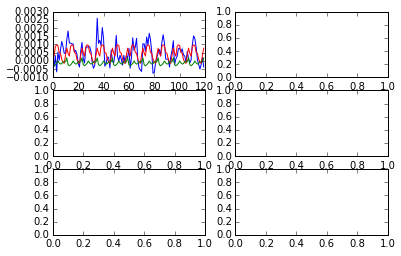

In [71]:
fig, axes = plt.subplots(3,2)
yp =10
ax_ind = 0
ord_var = ['Eu','Ev','Wu','Wv','Nu','Nv']
time = np.array(range(len(obcs_data['Eu'])))
time_obcs= np.array(range(len(obcs_data['Eu'])))
for var in ord_var:
    axes.flat[ax_ind].plot(time[0:360*yp],obcs_data_mean[var][0:360*yp],'b')
    axes.flat[ax_ind].plot(time[0:360*yp],obcs_data_ave_mean[var][0:360*yp],'r')    
    axes.flat[ax_ind].plot(time[0:360*yp],obcs_data_ave_mean_div[var][0:360*yp],'g')
    axes.flat[ax_ind].plot(time[0:360*yp],obcs_data_mean_18[var][0:360*yp],'orange')
    axes.flat[ax_ind].plot(time[0:360*yp],obcs_data_ave_mean_18[var][0:360*yp],'purple')
    
    axes.flat[ax_ind].set_title(titles_obcs[var])
    axes.flat[ax_ind].set_ylabel(unity_obcs[var])
    ax_ind +=  1
    yp = 10
fig.subplots_adjust(right=2.1,top=2.4)

print 'Blue=original, Red=average, Green=average zero flux, Orange=original 18km, Purple=average18km'

In [ ]:
fig, axes = plt.subplots(3,2)
yp =30
ax_ind = 0
ord_var = ['Es','Et','Ws','Wt','Ns','Nt']
time = np.array(range(len(obcs_data['Eu'])))
for var in ord_var:
    axes.flat[ax_ind].plot(time[0:360*yp],obcs_data_mean[var][0:360*yp],'b')
    axes.flat[ax_ind].plot(time[0:360*yp],obcs_data_ave_mean[var][0:360*yp],'r')
    axes.flat[ax_ind].plot(time[0:360*yp],obcs_data_mean_18[var][0:360*yp],'orange')
    axes.flat[ax_ind].plot(time[0:360*yp],obcs_data_ave_mean_18[var][0:360*yp],'purple')
    axes.flat[ax_ind].set_title(titles_obcs[var])
    axes.flat[ax_ind].set_ylabel(unity_obcs[var])
    ax_ind +=  1
    yp = 30
fig.subplots_adjust(right=2.1,top=2.4)
print 'Blue=original, Red=average, Green=average zero flux, Orange=original 18km, Purple=average18km'

In [ ]:
Wv_flux, Wu_flux, Ev_flux, Eu_flux, Nv_flux, Nu_flux = calculate_fluxes_ob(obcs_data,36)
Wv_flux_ave, Wu_flux_ave, Ev_flux_ave, Eu_flux_ave, Nv_flux_ave, Nu_flux_ave = calculate_fluxes_ob(obcs_data_ave,36)
Wv_flux_ave_div, Wu_flux_ave_div, Ev_flux_ave_div, Eu_flux_ave_div, Nv_flux_ave_div, Nu_flux_ave_div = calculate_fluxes_ob(obcs_data_ave_div,36)
Wv_flux_18, Wu_flux_18, Ev_flux_18, Eu_flux_18, Nv_flux_18, Nu_flux_18 = calculate_fluxes_ob(obcs_data_18,18)
Wv_flux_ave_18, Wu_flux_ave_18, Ev_flux_ave_18, Eu_flux_ave_18, Nv_flux_ave_18, Nu_flux_ave_18 = calculate_fluxes_ob(obcs_data_ave_18,18)

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2)

axes[0,0].plot(Wv_flux,'b')
axes[0,0].plot(Wv_flux_ave,'r')
axes[0,0].plot(Wv_flux_ave_div,'g')
axes[0,0].plot(Wv_flux_18,'orange')
axes[0,0].plot(Wv_flux_ave_18,'purple')
axes[0,0].set_title('West V flux')

axes[0,1].plot(Wu_flux,'b')
axes[0,1].plot(Wu_flux_ave,'r')
axes[0,1].plot(Wu_flux_ave_div,'g')
axes[0,1].plot(Wu_flux_18,'orange')
axes[0,1].plot(Wu_flux_ave_18,'purple')
axes[0,1].set_title('West U flux')


axes[1,0].plot(Ev_flux,'b')
axes[1,0].plot(Ev_flux_ave,'r')
axes[1,0].plot(Ev_flux_ave_div,'g')
axes[1,0].plot(Ev_flux_18,'orange')
axes[1,0].plot(Ev_flux_ave_18,'purple')
axes[1,0].set_title('East V flux')

axes[1,1].plot(Eu_flux,'b')
axes[1,1].plot(Eu_flux_ave,'r')
axes[1,1].plot(Eu_flux_ave_div,'g')
axes[1,1].plot(Eu_flux_18,'orange')
axes[1,1].plot(Eu_flux_ave_18,'purple')
axes[1,1].set_title('East U flux')

axes[2,0].plot(Nv_flux,'b')
axes[2,0].plot(Nv_flux_ave,'r')
axes[2,0].plot(Nv_flux_ave_div,'g')
axes[2,0].plot(Nv_flux_18,'orange')
axes[2,0].plot(Nv_flux_ave_18,'purple')
axes[2,0].set_title('North V flux')

axes[2,1].plot(Nu_flux,'b')
axes[2,1].plot(Nu_flux_ave,'r')
axes[2,1].plot(Nu_flux_ave_div,'g')
axes[2,1].plot(Nu_flux_18,'orange')
axes[2,1].plot(Nu_flux_ave_18,'purple')
axes[2,1].set_title('North U flux')

axes[3,0].plot(Wu_flux - Eu_flux - Nv_flux,'b')
axes[3,0].plot(Wu_flux - Eu_flux - Nv_flux,'b')
axes[3,0].plot(Wu_flux_ave - Eu_flux_ave - Nv_flux_ave,'r')
axes[3,0].plot(Wu_flux_ave_div - Eu_flux_ave_div - Nv_flux_ave_div,'g')
axes[3,0].plot(Wu_flux_18 - Eu_flux_18 - Nv_flux_18,'orange')
axes[3,0].plot(Wu_flux_ave_18 - Eu_flux_ave_18 - Nv_flux_ave_18,'purple')
axes[3,0].set_title('East_u + West_u + North_v')

axes[3,1].plot(-Wu_flux + Eu_flux + Nv_flux,'b')
axes[3,1].plot(-Wu_flux + Eu_flux + Nv_flux,'b')
axes[3,1].plot(-Wu_flux_ave + Eu_flux_ave + Nv_flux_ave,'r')
axes[3,1].plot(-Wu_flux_ave_div + Eu_flux_ave_div + Nv_flux_ave_div,'g')
axes[3,1].plot(-Wu_flux_18 + Eu_flux_18 + Nv_flux_18,'orange')
axes[3,1].plot(-Wu_flux_ave_18 + Eu_flux_ave_18 + Nv_flux_ave_18,'purple')
axes[3,1].set_title('East_u + West_u + North_v')

fig.subplots_adjust(right=2.2,top=2.8)
print 'Blue=original, Red=average, Green=average zero flux, Orange=original 18km, Purple=average18km'